In [1]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools

In [2]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [3]:
def list_itr(netname):
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    f = _FILEDIR_ + '/' + _FILEMAP_[netname]
    itr_v = [int(f.rstrip('.csv').split('_')[-1]) for f in commands.getoutput('ls %s*csv' % f).split() if f.endswith('csv')]
    itr_v.sort()
    return itr_v

def get_df(netname,itr):
    key=(netname,itr)
    if key in _DATAMAP_:
        return _DATAMAP_[key]
    
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    
    itr_v = list_itr(netname)
    if not itr in itr_v:
        print 'Iteration',itr,'not found'
        return None

    f = _FILEDIR_ + '/' + _FILEMAP_[netname] + str(itr) + '.csv'
    if not os.path.isfile(f):
        print 'LOGIC ERROR ... file not found (should not happen):',f
        return None
    
    df = pd.read_csv(f)
    _DATAMAP_[key] = df
    return _DATAMAP_[key]

Network resnet29b

Iterations [428000, 428250, 428500, 428750, 429000, 429250, 429500, 429750, 430000, 430250, 430500, 430750, 431000, 431250, 431500, 431750, 432000, 432250, 432500, 432750, 433000, 433250, 433500]



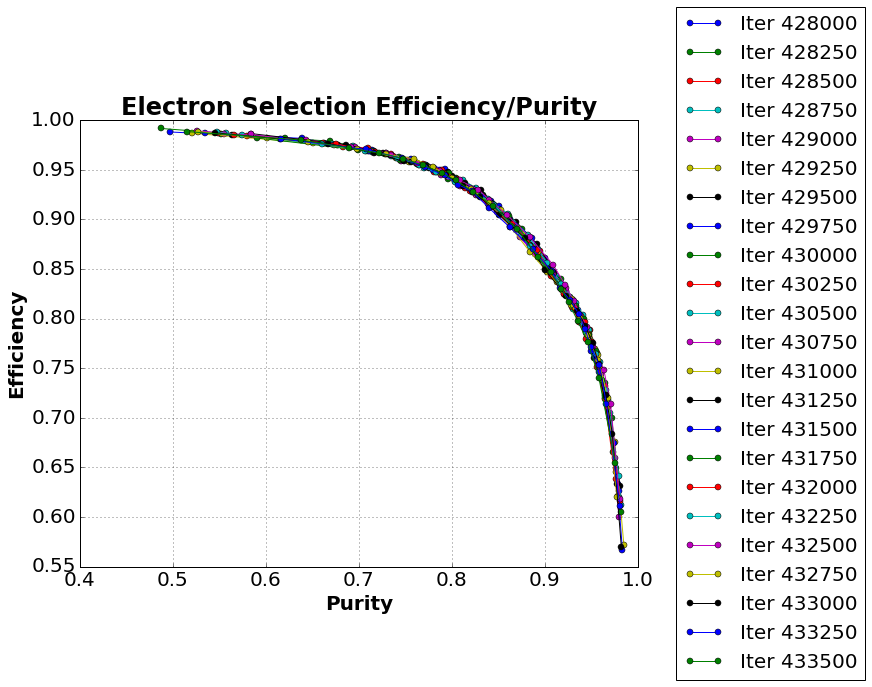

In [5]:
#
# Effiency vs Purity
#

#
# Configurations
#
# network name
netname='resnet29b'

# Report network name
print 'Network',netname
print

# Report available list of iterations
itr_v = list_itr(netname)
print 'Iterations',itr_v
print

eff_map={}
pur_map={}
# Loop over iterations and print accuracy
for itr in itr_v:
    # Get data frame
    df = get_df(netname,itr)
    #print "ITER ", itr
    eminus_df = df.query('label==0')
    gamma_df  = df.query('label==1')
    eminus_data = np.array(eminus_df.eminus.values, dtype='float')
    gamma_data  = np.array(gamma_df.eminus.values,  dtype='float')
    
    efficiency = []
    purity = [] 
        
    for x in xrange(19):
        score_threshold = 0.05 + x*0.05
        num_selected_eminus = len(eminus_df.query('eminus/(eminus+gamma) > %g' % score_threshold))
        num_selected_gamma  = len(gamma_df.query('eminus/(eminus+gamma) > %g' % score_threshold))
        efficiency.append(float(num_selected_eminus) / len(eminus_data))
        purity.append(1 - float(num_selected_gamma) / len(gamma_data)) 
        
    eff_map[itr] = efficiency
    pur_map[itr] = purity
    

fig, ax = plt.subplots(figsize=(10, 8),facecolor='w')
for netkey in itr_v:
    plt.plot(pur_map[netkey],eff_map[netkey],marker='o',label="Iter %i" %netkey) #,color=color,label=netkey)
    
plt.tick_params(labelsize=20)
plt.grid()
plt.ylabel('Efficiency',fontsize=20,fontweight='bold')
plt.xlabel('Purity',fontsize=20,fontweight='bold')
plt.legend(fontsize=20,loc='center left', bbox_to_anchor=(1.05, 0.5))
#leg_frame=leg.get_frame()
#leg_frame.set_facecolor('white')
plt.title('Electron Selection Efficiency/Purity',fontsize=24,fontweight='bold')
plt.show() 